# 過学習

学習済みモデルの評価や過学習という課題、そしてその対策について。

In [1]:
import numpy as np
np.random.seed(11)
import matplotlib.pyplot as plt


---

## モデルの評価

学習済みモデルをどう評価しようかという話。

基本的にはモデルの予測値が正解とどれだけ近いかを評価する。その評価指標は色々あり、例えば回帰だったら平均二乗誤差とか、それを正規化した決定係数とか、また分類だったら正解率とか。

これらの指標を求めるためにはモデルへの入力と正解のペアが適当な数必要になるが、それらはどこから得ると良いだろう。学習させたデータから適当に持ってくると良いと思うかもしれないが、それではモデルの**汎化性能**を測れない。学習時にモデルが見なかった「未知のデータ」に対してどのようなパフォーマンスを発揮するかが測れない。

そこで、評価指標の算出には学習時に使わなかったデータを用いるようにする。用意したデータの一部は学習に使用せず残しておき、学習後にそのデータを使って評価指標を算出するということ。学習に使用するデータは**訓練データ**、評価に使用するデータは**テストデータ**と呼ぶ。

やってみよう。

In [2]:
# サンプルデータの読み込み
from sklearn.datasets import load_diabetes
X, y = load_diabetes(return_X_y=True)

これを訓練データとテストデータに分ける。

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=11
)
len(X_train), len(X_test)

(353, 89)

ランダムで4:1に分けられた。ここから訓練データ（`X_train, y_train`）を学習させ、テストデータ（`X_test, y_test`）で評価する。評価指標は決定係数とする。1に近いほど良い。

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test) # 決定係数

0.5771689611166473

これで汎化性能を考慮した評価ができた。


---

## 過学習

*Overfitting*

訓練データでの性能は良いがテストデータでの性能が悪い、という状態。訓練データに過剰に適合してしまっており、汎化性能が低い。

例えば、こんなサンプルがあるとする。

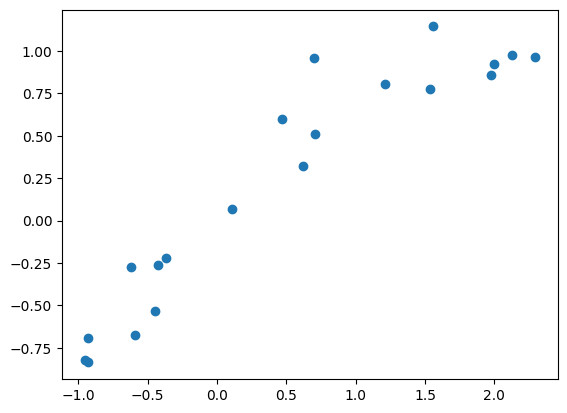

In [5]:
x_range = (-1, 2.5)
def get_samples(n):
    x = np.random.uniform(*x_range, n)
    y = np.sin(x) + 0.2 * np.random.randn(n)
    return x.reshape(-1, 1), y

X, y = get_samples(20)
plt.scatter(X, y);

これを半分に分け、訓練データ、テストデータとする。

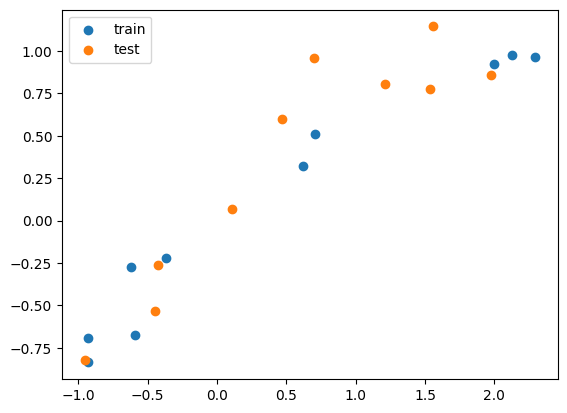

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=11
)
plt.scatter(X_train, y_train, label="train")
plt.scatter(X_test, y_test, label="test")
plt.legend();

この訓練データに10次の多項式を適合させ、評価してみる。

score (train): 1.00
score (test): -104.33


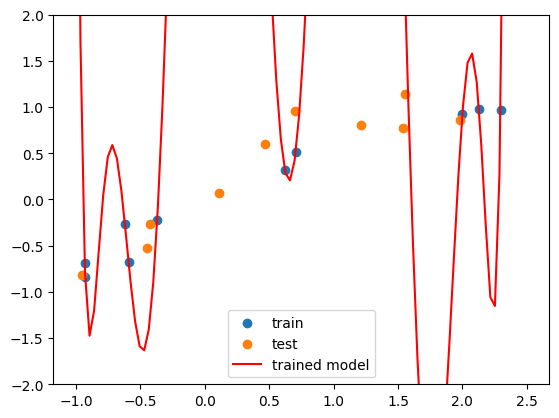

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

def evaluate(model, X_train, X_test, y_train, y_test):
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    print(f"score (train): {score_train:.2f}")
    print(f"score (test): {score_test:.2f}")

    x_axis = np.linspace(*x_range, 100).reshape(-1, 1)
    y_pred = model.predict(x_axis)
    plt.scatter(X_train, y_train, label="train")
    plt.scatter(X_test, y_test, label="test")
    plt.plot(x_axis, y_pred, color="red", label="trained model")
    plt.ylim(-2, 2)
    plt.legend()


poly = PolynomialFeatures(degree=10, include_bias=False)
model = LinearRegression()
pipeline = Pipeline([("poly", poly), ("model", model)])
pipeline.fit(X_train, y_train)
evaluate(pipeline, X_train, X_test, y_train, y_test)

10次のモデルなのでかなり複雑な曲線になった。このモデルは訓練データには適合しているが、テストデータには全く適合していない。図からも決定係数からも分かる。これが正に、過学習が起こっている状態である。訓練データのみに過剰に適合している状態。

では、どうすれば過学習を防げるだろう。色々な手法があるので紹介する。

まず、モデルの複雑さを抑えること。今回で言うと、多項式の次数を下げること。表現力が高すぎるモデルは過学習を起こしやすい。

試しに次数を3に下げてみる。

score (train): 0.98
score (test): 0.88


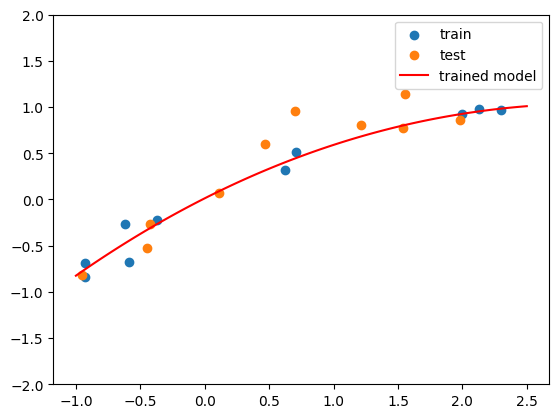

In [8]:
poly = PolynomialFeatures(degree=3, include_bias=False) # 多項式の次数を3に変更
model = LinearRegression()
pipeline = Pipeline([("poly", poly), ("model", model)])
pipeline.fit(X_train, y_train)
evaluate(pipeline, X_train, X_test, y_train, y_test)

決定係数はどちらも高い値となり、図からもモデルが適切に適合していることがわかる。

もう一つの手法は、データを増やすこと。多様なデータを与えることで過学習が抑制される。

score (train): 0.91
score (test): 0.84


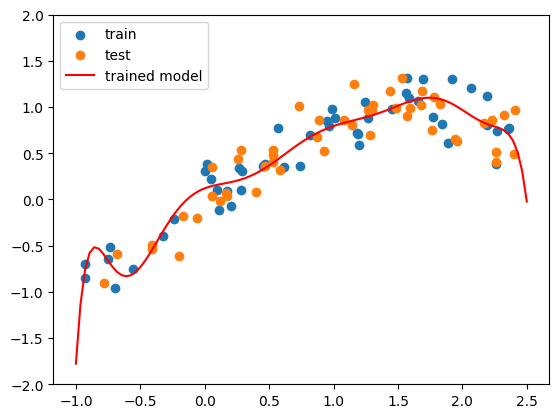

In [9]:
poly = PolynomialFeatures(degree=10, include_bias=False)
model = LinearRegression()
pipeline = Pipeline([("poly", poly), ("model", model)])
X, y = get_samples(100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=11
)
pipeline.fit(X_train, y_train)
evaluate(pipeline, X_train, X_test, y_train, y_test)

データ数を20から100に増やした。これにより、10次のモデルでも過学習が抑制された。